In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

In [2]:
ks.shape

(378661, 15)

In [3]:
ks.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [4]:
# Drop live projects
ks = ks.query('state != "live"')

In [5]:
ks.shape

(375862, 15)

In [6]:
# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

In [7]:
# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

In [8]:
ks.shape

(375862, 20)

In [9]:
ks.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0,8,4,7,2015


In [10]:
# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

In [11]:
baseline_data.shape

(375862, 9)

In [12]:
baseline_data.head(5)

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22


In [13]:
# Defining  functions that will help us test our encodings
import lightgbm as lgb
from sklearn import metrics

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

In [14]:
# Training a model on the baseline data
train, valid, _ = get_data_splits(baseline_data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7467


## One Hot Encoding

In [15]:
ks['category'].unique().size

159

In [16]:
ks['currency'].unique().size

14

In [17]:
ks['country'].unique().size

23

In [18]:
import category_encoders as ce
one_hot_enc = ce.OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(ks[cat_features])

data = baseline_data.join(one_hot_encoded.add_suffix("_oh"))

In [19]:
data.shape

(375862, 205)

In [20]:
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7490


## Binary Encoding

In [21]:
binary_enc = ce.BinaryEncoder()
binary_encoded = binary_enc.fit_transform(ks[cat_features])

data = baseline_data.join(binary_encoded.add_suffix("_binary"))

In [22]:
data.shape

(375862, 29)

In [23]:
data.columns

Index(['goal', 'hour', 'day', 'month', 'year', 'outcome', 'category',
       'currency', 'country', 'category_0_binary', 'category_1_binary',
       'category_2_binary', 'category_3_binary', 'category_4_binary',
       'category_5_binary', 'category_6_binary', 'category_7_binary',
       'category_8_binary', 'currency_0_binary', 'currency_1_binary',
       'currency_2_binary', 'currency_3_binary', 'currency_4_binary',
       'country_0_binary', 'country_1_binary', 'country_2_binary',
       'country_3_binary', 'country_4_binary', 'country_5_binary'],
      dtype='object')

In [24]:
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7487


## Count Encoding

In [25]:
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(ks[cat_features])

data = baseline_data.join(count_encoded.add_suffix("_count"))

# Training a model on the baseline data
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7486


## Target Encoding

In [26]:
target_enc = ce.TargetEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)

# Fit the encoder using the categorical features and target
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

train.head()
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7491


## CatBoost Encoding

In [27]:
target_enc = ce.CatBoostEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)
target_enc.fit(train[cat_features], train['outcome'])

train = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_cb'))

bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7492


# Feature Generation

## Interacciones

In [28]:
interactions = ks['category'] + "_" + ks['country']
print(interactions.head(10))

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
5       Restaurants_US
6              Food_US
7            Drinks_US
8    Product Design_US
9       Documentary_US
dtype: object


In [29]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


## Número de proyectos en la última semana

In [30]:
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


/home/damu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


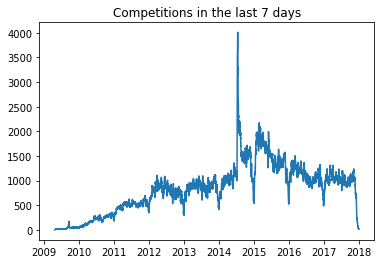

In [32]:
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

In [33]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

count_7_days.head(10)

In [34]:
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


## Tiempo desde el último proyecto en la misma categoría

In [35]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


In [36]:
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


In [37]:
baseline_data.join(timedeltas.rename({'launched': 'time_since_last_project'}, axis=1)).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,time_since_last_project
0,1000.0,12,11,8,2015,0,108,5,9,18.606111
1,30000.0,4,2,9,2017,0,93,13,22,5.592778
2,45000.0,0,12,1,2013,0,93,13,22,1.313611
3,5000.0,3,17,3,2012,0,90,13,22,0.635000
4,19500.0,8,4,7,2015,0,55,13,22,16.661389
5,50000.0,13,26,2,2016,1,123,13,22,2.629722
6,1000.0,18,1,12,2014,1,58,13,22,0.367500
7,25000.0,20,1,2,2016,0,41,13,22,12.286111
8,125000.0,18,24,4,2014,0,113,13,22,14.243611
9,65000.0,21,11,7,2014,0,39,13,22,0.174722


# Transformación de features numéricos

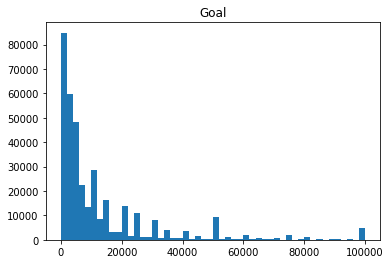

In [38]:
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');

In [39]:
import numpy as np

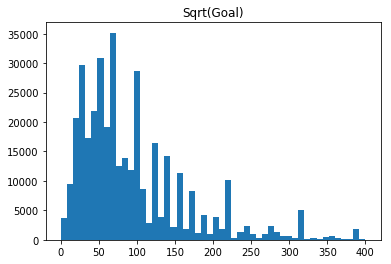

In [40]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

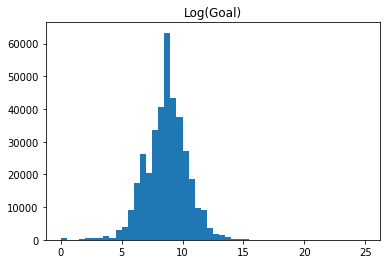

In [41]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

In [42]:
ks['goal_log'] = np.log(ks.goal)

In [43]:
ks.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,country,usd pledged,usd_pledged_real,usd_goal_real,outcome,hour,day,month,year,goal_log
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,GB,0.0,0.0,1533.95,0,12,11,8,2015,6.907755
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,US,100.0,2421.0,30000.00,0,4,2,9,2017,10.308953
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,US,220.0,220.0,45000.00,0,0,12,1,2013,10.714418
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,US,1.0,1.0,5000.00,0,3,17,3,2012,8.517193
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,US,1283.0,1283.0,19500.00,0,8,4,7,2015,9.878170


# Feature Selection

## Univariate Feature Selection

Medir cuanto depende el target de cada feature.
Se debe elegir una funcion de scoring: X^2, ANOVA F-value, mutual information score.

### f_classif

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

feature_cols = baseline_data.columns.drop('outcome')
train, valid, _ = get_data_splits(baseline_data)

selector = SelectKBest(f_classif, k=3)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

array([[2.015e+03, 5.000e+00, 9.000e+00],
       [2.017e+03, 1.300e+01, 2.200e+01],
       [2.013e+03, 1.300e+01, 2.200e+01],
       ...,
       [2.011e+03, 1.300e+01, 2.200e+01],
       [2.015e+03, 1.000e+00, 3.000e+00],
       [2.013e+03, 1.300e+01, 2.200e+01]])

In [45]:
baseline_data.shape

(375862, 9)

In [46]:
X_new.shape

(300690, 3)

In [48]:
feature_cols

Index(['goal', 'hour', 'day', 'month', 'year', 'category', 'currency',
       'country'],
      dtype='object')

In [47]:
selector.scores_

array([ 176.44548895,   27.78178553,   78.43201755,   35.47464461,
       2161.42005091,  175.92221881, 1359.91885484, 1293.74304514])

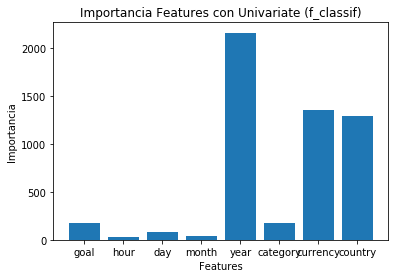

In [50]:
plt.bar(feature_cols, selector.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (f_classif)')
plt.show()

In [51]:
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country
0,0.0,0.0,0.0,0.0,2015.0,0.0,5.0,9.0
1,0.0,0.0,0.0,0.0,2017.0,0.0,13.0,22.0
2,0.0,0.0,0.0,0.0,2013.0,0.0,13.0,22.0
3,0.0,0.0,0.0,0.0,2012.0,0.0,13.0,22.0
4,0.0,0.0,0.0,0.0,2015.0,0.0,13.0,22.0


In [52]:
selected_columns = selected_features.columns[selected_features.var() != 0]

In [53]:
selected_columns

Index(['year', 'currency', 'country'], dtype='object')

In [54]:
valid[selected_columns].head()

,year,currency,country
302896,2015,13,22
302897,2013,13,22
302898,2014,5,9
302899,2014,13,22
302900,2014,5,9


### chi2

In [55]:
selector_chi2 = SelectKBest(chi2, k=3)

X_new = selector_chi2.fit_transform(train[feature_cols], train['outcome'])

In [56]:
selector_chi2.scores_

array([4.99855268e+09, 1.26053903e+02, 3.98590901e+02, 6.03993972e+01,
       3.94426051e+00, 4.42256496e+03, 1.91106807e+03, 2.68209037e+03])

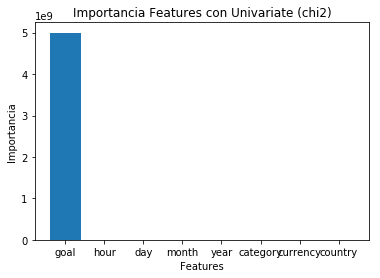

In [57]:
plt.bar(feature_cols, selector_chi2.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (chi2)')
plt.show()

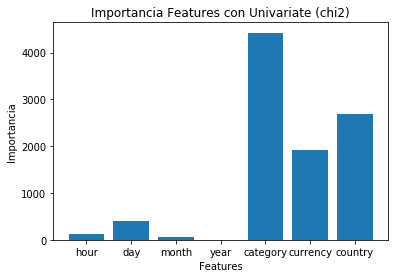

In [58]:
plt.bar(feature_cols[1:], selector_chi2.scores_[1:])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (chi2)')
plt.show()

### mutual_info_classif

In [59]:
selector_mutual = SelectKBest(mutual_info_classif, k=3)

X_new = selector_mutual.fit_transform(train[feature_cols], train['outcome'])

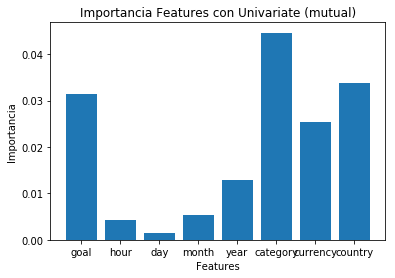

In [60]:
plt.bar(feature_cols, selector_mutual.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (mutual)')
plt.show()

## L1 regularization (Lasso Regression)

Penalización al aumentar la complejidad del modelo

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7).fit(X, y)

/home/damu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [62]:
logistic.coef_

array([[-1.60948774e-05,  3.52696292e-03, -4.01805702e-03,
        -5.35315567e-03, -1.38150607e-04,  1.49581585e-03,
         1.91222965e-02,  9.19151006e-03]])

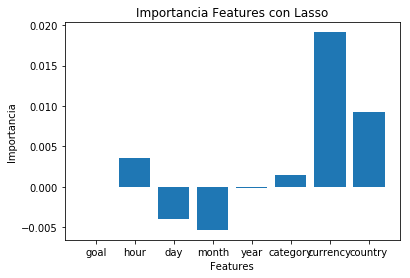

In [63]:
plt.bar(feature_cols, logistic.coef_[0])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Lasso')
plt.show()

In [64]:
model = SelectFromModel(logistic, prefit=True, max_features=3)

X_new = model.transform(X)

In [65]:
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country
0,0.0,0.0,0.0,8.0,0.0,0.0,5.0,9.0
1,0.0,0.0,0.0,9.0,0.0,0.0,13.0,22.0
2,0.0,0.0,0.0,1.0,0.0,0.0,13.0,22.0
3,0.0,0.0,0.0,3.0,0.0,0.0,13.0,22.0
4,0.0,0.0,0.0,7.0,0.0,0.0,13.0,22.0


## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

X, y = train[train.columns.drop("outcome")], train['outcome']
val_X, val_y = valid[valid.columns.drop("outcome")], valid['outcome']

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X, y)
preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, preds))

/home/damu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.33802479646676953


In [67]:
forest_model.feature_importances_

array([0.22753218, 0.14630286, 0.19871761, 0.12663167, 0.05700985,
       0.21927226, 0.01028908, 0.01424449])

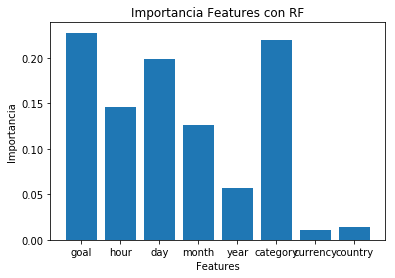

In [68]:
plt.bar(feature_cols, forest_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [69]:
model = SelectFromModel(forest_model, prefit=True, max_features=3)

X_new = model.transform(X)

In [70]:
X_new

array([[1.00e+03, 1.10e+01, 1.08e+02],
       [3.00e+04, 2.00e+00, 9.30e+01],
       [4.50e+04, 1.20e+01, 9.30e+01],
       ...,
       [2.50e+03, 3.00e+00, 1.04e+02],
       [2.60e+03, 2.30e+01, 5.80e+01],
       [2.00e+04, 4.00e+00, 5.20e+01]])